<a href="https://colab.research.google.com/github/hesolar/TrabajoDistribuidos2020solar-escudero/blob/master/practica7_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 7. Ejercicio adicional 2: Sudoku. Parte I

En este ejercicio adicional vamos a crear la primera parte de una aplicación que sea capaz de "observar" un Sudoku y resolverlo. En concreto en esta primera parte vamos a detectar el tablero del Sudoku, sus casillas y si dichas casillas están vacías o contienen un número (por el momento no identificaremos el número que contiene). 

Todos los tableros de Sudoku que utilizaremos en esta parte de la práctica han sido extraídos desde http://www.sudoku-online.org/imprimir-sudokus.php.


Comenzamos cargando las librerías necesarias y definiendo la funcionalidad para mostrar imágenes.



In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
%matplotlib inline 

In [4]:
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

En caso de que hayas reiniciado el entorno, deberás volver a descargar las imágenes de la parte obligatoria de la práctica. 

In [ ]:
!wget https://github.com/IA1819/Datasets/blob/master/im%C3%A1genes.zip?raw=true -O imagenes.zip
!unzip imagenes.zip

A continuación cargamos una imagen de un tablero de Sudoku.

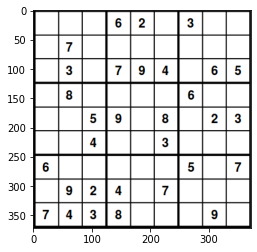

In [6]:
sudoku1 = cv2.imread("imágenes/sudoku1.png")
mostrarImagen(sudoku1)

A continuación debes implementar la funcionalidad para detectar las casillas del Sudoku siguiendo los siguientes pasos.

Comienza clonando la imagen del Sudoku.

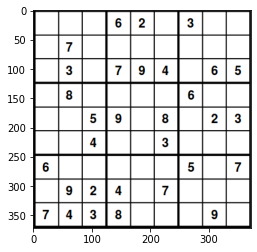

In [9]:
image = cv2.imread("imágenes/sudoku1.png")
mostrarImagen(sudoku1)

Transforma la imagen del Sudoku a escala de grises.

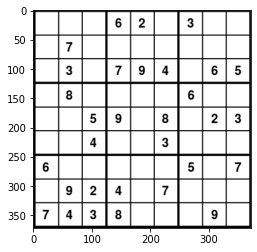

In [11]:
sudokuGrayScale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
mostrarImagen(sudokuGrayScale)


Umbraliza la imagen utilizando como valor de umbral 30. 

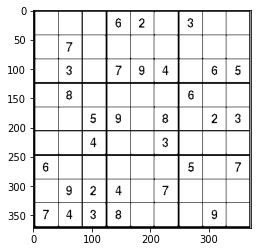

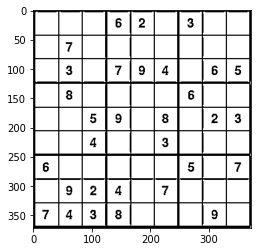

In [40]:
th3 = cv2.adaptiveThreshold(sudokuGrayScale,30,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,(2))
ret,th1 = cv2.threshold(sudokuGrayScale,30,255,cv2.THRESH_BINARY)           
mostrarImagen(th1)
mostrarImagen(th3)

Localiza los contornos en la imagen umbralizada, pero en lugar de usar el método `cv2.RETR_EXTERNAL` utiliza el método `cv2.RETR_LIST` esto te permitirá encontrar los contornos internos y externos de la imagen. 

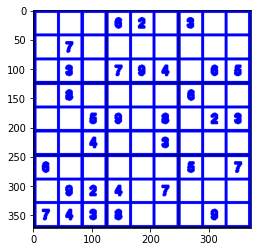

In [54]:
cnts,_ = cv2.findContours(th1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
clone = image.copy()
cv2.drawContours(clone, cnts, -1, (255, 0, 0), 2)
mostrarImagen(clone)

Muestra los contornos de la imagen y sus propiedades. El objetivo es encontrar las casillas del tablero, para descartar aquellos elementos del tablero que no son casillas puedes tener en cuenta que la solidity y el aspect ratio de las casillas debe tener un valor cercano a 1; además las casillas han de tener un área mínima (que te permitirá descartar objetos) y un área máxima (no queremos detectar el tablero). 

In [ ]:
clone = th1.copy()
for (i, c) in enumerate(cnts):
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)
    print("Contorno #{} -- area: {:.2f}, perimetro: {:.2f}".format(i + 1, area, perimetro))
 
    cv2.drawContours(clone, [c], -1, (0, 255, 0), 2)
 
    # Dibujamos el identificador de cada contorno
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    cv2.putText(clone, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 255, 255), 4)
mostrarImagen(clone)

Una vez has detectado los contornos de las casillas, debes darte cuenta de que dichos contornos no están ordenados (en ocasiones anteriores el orden no era importante, pero ahora sí que lo es). Para ordenar los contornos de izquierda a derecha y de arriba a abajo puedes utilizar la siguiente función. 

In [57]:
def sort_contours(cnts):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:(b[1][1],b[1][0]), reverse=False))
    return cnts

Utiliza la función anterior para ordenar los contornos de las casillas. 

In [ ]:
cnts,_ = cv2.findContours(th1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts=sort_contours(cnts)


Pasamos ahora a determinar si una casilla contiene un número dentro. Para ello primero define una función que dada una imagen, compruebe si la imagen es completamente blanca (es decir todos sus píxeles tienen valor igual a 255), si dicha lista es vacía devuelve el carácter '.' en caso contrario devuelve el carácter '?' (recuerda que esta era la notación que usabamos en la práctica 4 para representar los sudokus).

In [75]:
def todosBlancos(th1):
  x=True
  for a in range(th1.shape[0]):
    for b in range(th1.shape[1]):
      if th1[a][b]!=255:
        x=False
  if x:
    return '.'
  else:
    return '?'

A continuación debes recortar cada uno de los contornos de las casillas de la imagen del Sudoku y pasárselo a la función anterior. 

In [158]:
clone = th1.copy()
sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []

# Iterate through each box
for row in sudoku_rows:
    for c in row:
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(image, mask)
        result[mask==0] = 255
        cv2.imshow('result', result)
        cv2.waitKey(175)


In [163]:
for row in sudoku_rows:
    mostrarImagen(row)
    for c in row:
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(image, mask)
        result[mask==0] = 255
        cv2.imshow('result', result)
        cv2.waitKey(175)


Finalmente define una función que a partir de cualquier del path de cualquier imagen de Sudoku sea capaz de extraer el tablero con la notación dada. Comprueba que los resultados son los esperados. 

In [ ]:
def generaTablero(imagenPath):
    ???

In [ ]:
generaTablero("imágenes/sudoku1.png")

In [ ]:
generaTablero("imágenes/sudoku2.png")

In [ ]:
generaTablero("imágenes/sudoku3.png")

In [ ]:
import cv2
from imutils import contours
import numpy as np

# Load image, grayscale, and adaptive threshold
#image = cv2.imread('1.png')
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
thresh=th1

# Filter out all numbers and noise to isolate only boxes
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

# Sort by top to bottom and each row by left to right
invert = 255 - thresh
cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
(cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            sudoku_rows.append(cnts)
            row = []

# Iterate through each box
for row in sudoku_rows:
    for c in row:
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(image, mask)
        result[mask==0] = 255
        cv2.imshow('result', result)
        cv2.waitKey(175)

cv2.imshow('thresh', thresh)
cv2.imshow('invert', invert)
cv2.waitKey()

# Guarda este fichero con tus soluciones a los distintos ejercicios usando la opción *"Save in Github..."*. 